<a href="https://colab.research.google.com/github/kane689/Capstone-Project---The-Battle-of-Neighborhoods/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install geopy to access geocoder package
!pip install geopy

In [ ]:
# install beautifulsoup4 for web scraping
!pip install beautifulsoup4
# install requests to gain access to an URL
!pip install requests
# install kmeans for clustering
!pip install kmeans
# install folium for visualization
!pip install folium
# install sklearn
!pip install -U scikit-learn

  Created wheel for kmeans: filename=kmeans-1.0.2-cp37-cp37m-linux_x86_64.whl size=11792 sha256=9792febacd8067f66f9b700970bb42cd36035b476a959af8dcc6ad43c0fee550
  Stored in directory: /root/.cache/pip/wheels/4a/26/51/688c6987fdc6a10c6186c3817f2ef7c92c50c078a900525c0e
Successfully built kmeans
     |████████████████████████████████| 22.3 MB 54.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
# import all necessary libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from bs4 import BeautifulSoup
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [ ]:
# Get the neighborhood data using beautiful soup 
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

# read the data into a Pandas Dataframe
soup = BeautifulSoup(str(data_html))

In [ ]:
# loop through table, grab each of the 3 columns shown
# Scrape the neighborhood data from the table in the wikipedia page of Toronto
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
      # Create three columns named as "PostalCode","Borough" & "Neighborhood"
        cell['PostalCode'] = row.p.text[:3] # store only first three letter from the test of <p> tab.(Ex: M3A )
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        # here we replace some symbols like "(" , ")" , "/" from the neighborhood name(Ex: (Parkview Hill / Woodbine Gardens))
        table_contents.append(cell)

df=pd.DataFrame(table_contents)
# compress some big borough name by smaller one
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

In [ ]:
# save this dataframe in a CSV file
df.to_csv('Neighborhood Data.csv')

In [ ]:
# drop rows having null value and value assigned as "Not assigned"
df_dropna = df.dropna()
empty = 'Not assigned'
df_dropna = df_dropna[(df_dropna.PostalCode != empty ) & (df_dropna.Borough != empty) & (df_dropna.Neighborhood != empty)].reset_index(drop=True)

In [ ]:
# check for missing value
df_dropna.isnull().sum()

PostalCode      0
Borough         0
Neighborhood    0
dtype: int64

In [ ]:
# Check if we still have any Neighborhoods that are Not Assigned
df_dropna.loc[df_dropna['Borough'].isin(["Not assigned"])]

Empty DataFrame
Columns: [PostalCode, Borough, Neighborhood]
Index: []

In [ ]:
df = df_dropna
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

In [ ]:
# shape of dataframe
df.shape

(103, 3)

In [ ]:
# get the latitude and the longitude coordinates of each Postal code
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

In [ ]:
# Merging the Data
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [ ]:
# lets find out how many neighborhoods in each borough
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto            9
Downtown Toronto          17
Downtown Toronto Stn A     1
East Toronto               4
East Toronto Business      1
East York                  4
East York/East Toronto     1
Etobicoke                 11
Etobicoke Northwest        1
Mississauga                1
North York                24
Queen's Park               1
Scarborough               17
West Toronto               6
York                       5
Name: Neighborhood, dtype: int64

In [ ]:
df_toronto = df
df_toronto.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [ ]:
# Create a list and store all unique borough names
boroughs = df_toronto['Borough'].unique().tolist()

In [ ]:
# Obtain the Latitude and Longitude of Toronto by taking mean of Latitude/Longitude of all postal code
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165048


In [ ]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [ ]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
    
map_toronto

In [ ]:
CLIENT_ID = 'RFBIIGEGQHUKNCUCRNHRMQKSJZJX1EUEOFUYDWWAMNXTBY45' # your Foursquare ID
CLIENT_SECRET = '2Q1AWGGIYUTG52R1YAN5QIBBHJOLEFZUPGIKSNWPKKYQAJ54' # your Foursquare Secret
VERSION = '20200514' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)

Your credentails:
CLIENT_ID: RFBIIGEGQHUKNCUCRNHRMQKSJZJX1EUEOFUYDWWAMNXTBY45


In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [ ]:
toronto_venues.tail()

Neighborhood  \
2128  Mimico NW, The Queensway West, South of Bloor,...   
2129  Mimico NW, The Queensway West, South of Bloor,...   
2130  Mimico NW, The Queensway West, South of Bloor,...   
2131  Mimico NW, The Queensway West, South of Bloor,...   
2132  Mimico NW, The Queensway West, South of Bloor,...   

      Neighborhood Latitude  Neighborhood Longitude  \
2128              43.628841              -79.520999   
2129              43.628841              -79.520999   
2130              43.628841              -79.520999   
2131              43.628841              -79.520999   
2132              43.628841              -79.520999   

                                      Venue  Venue Latitude  Venue Longitude  \
2128            Islington Florist & Nursery       43.630156       -79.518718   
2129  Koala Tan Tanning Salon & Sunless Spa       43.631370       -79.519006   
2130                      Once Upon A Child       43.631075       -79.518290   
2131                          Value Village       43.631269       -79.518238   
2132                   Kingsway Boxing Club       43.627254       -79.526684   

              Venue Category  
2128             Flower Shop  
2129           Tanning Salon  
2130              Kids Store  
2131  Thrift / Vintage Store  
2132                     Gym

In [ ]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Agincourt                                                               5   
Alderwood, Long Branch                                                  7   
Bathurst Manor, Wilson Heights, Downsview North                        21   
Bayview Village                                                         4   
Bedford Park, Lawrence Manor East                                      25   
Berczy Park                                                            56   
Birch Cliff, Cliffside West                                             4   
Brockton, Parkdale Village, Exhibition Place                           22   
CN Tower, King and Spadina, Railway Lands, Harb...                     13   
Caledonia-Fairbanks                                                     4   
Cedarbrae                                                               9   
Central Bay Street                                                     64   
Christie                                                               15   
Church and Wellesley                                                   80   
Clairville, Humberwood, Woodbine Downs, West Hu...                      4   
Clarks Corners, Tam O'Shanter, Sullivan                                13   
Cliffside, Cliffcrest, Scarborough Village West                         3   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             37   
Davisville North                                                        9   
Del Ray, Mount Dennis, Keelsdale and Silverthorn                        4   
Don Mills North                                                         5   
Don Mills South                                                        21   
Dorset Park, Wexford Heights, Scarborough Town ...                      7   
Downsview Central                                                       3   
Downsview East                                                          2   
Downsview Northwest                                                     5   
Downsview West                                                          3   
Dufferin, Dovercourt Village                                           16   
Enclave of L4W                                                         14   
Enclave of M4L                                                         17   
Enclave of M5E                                                         95   
Eringate, Bloordale Gardens, Old Burnhamthorpe,...                      8   
Fairview, Henry Farm, Oriole                                           63   
First Canadian Place, Underground city                                100   
Forest Hill North & West                                                4   
Garden District, Ryerson                                              100   
Glencairn                                                               4   
Golden Mile, Clairlea, Oakridge                                        10   
Guildwood, Morningside, West Hill                                       9   
Harbourfront East, Union Station, Toronto Islands                     100   
High Park, The Junction South                                          24   
Hillcrest Village                                                       5   
Humber Summit                                                           1   
Humberlea, Emery                                                        1   
Humewood-Cedarvale                                                      4   
India Bazaar, The Beaches West                                         19   
Kennedy Park, Ionview, East Birchmount Park                             7   
Kensington Market, Chinatown, Grange Park                              68   
Kingsview Village, St. Phillips, Martin Grove G...                      4   
Lawrence Manor, Lawrence Heights                

In [ ]:
print('There are {} uniques vanue categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 276 uniques vanue categories.


In [ ]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Park' 'Fast Food Restaurant' 'Food & Drink Shop' 'Hockey Arena'
 'Coffee Shop' 'Portuguese Restaurant' 'Pizza Place' 'Bakery'
 'Distribution Center' 'Spa' 'Restaurant' 'Pub' 'Gym / Fitness Center'
 'Breakfast Spot' 'Historic Site' 'Chocolate Shop' 'Farmers Market'
 'Dessert Shop' 'Performing Arts Venue' 'Mexican Restaurant'
 'French Restaurant' 'Yoga Studio' 'Shoe Store' 'Theater' 'Café'
 'Event Space' 'Electronics Store' 'Art Gallery' 'Cosmetics Shop' 'Bank'
 'Beer Store' 'Health Food Store' 'Sushi Restaurant' 'Antique Shop'
 'Boutique' 'Furniture / Home Store' 'Vietnamese Restaurant'
 'Clothing Store' 'Accessories Store' "Women's Store"
 'Arts & Crafts Store' 'Italian Restaurant' 'Creperie' 'Beer Bar'
 'Burrito Place' 'Hobby Shop' 'Diner' 'Fried Chicken Joint'
 'Japanese Restaurant' 'Smoothie Shop' 'Sandwich Place' 'Gym'
 'College Auditorium' 'Bar' 'Vegetarian / Vegan Restaurant'
 'Caribbean Restaurant' 'Athletics & Sports' 'Gastropub' 'Pharmacy'
 'Intersec

In [ ]:
"Coffee Shop" in toronto_venues['Venue Category'].unique()

True

In [ ]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2133, 277)


Neighborhoods  Accessories Store  Adult Boutique  Airport  \
0         Parkwoods                  0               0        0   
1         Parkwoods                  0               0        0   
2         Parkwoods                  0               0        0   
3  Victoria Village                  0               0        0   
4  Victoria Village                  0               0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
3                   0             0               0                0   
4                   0             0               0                0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0                 0                    0             0         0            0   
1                 0                    0             0         0            0   
2                 0                    0             0         0            0   
3                 0                    0             0         0            0   
4                 0                    0             0         0            0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0           0                    0                 0                   0   
1           0                    0                 0                   0   
2           0                    0                 0                   0   
3           0                    0                 0                   0   
4           0                    0                 0                   0   

   Auto Garage  Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  \
0            0              0          0           0           0       0   
1            0              0          0           0           0       0   
2            0              0          0           0           0       0   
3            0              0          0           0           0       0   
4            0              0          0           0           0       0   

   Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0     0    0               0                 0                 0   
1     0    0               0                 0                 0   
2     0    0               0                 0                 0   
3     0    0               0                 0                 0   
4     0    0               0                 0                 0   

   Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  Beer Store  \
0                   0      0                0         0           0   
1                   0      0                0         0           0   
2                   0      0                0         0           0   
3                   0      0                0         0           0   
4                   0      0                0         0           0   

   Belgian Restaurant  Bike Shop  Bistro  Boat or Ferry  Bookstore  Boutique  \
0                   0          0       0              0          0         0   
1                   0          0       0              0          0         0   
2                   0          0       0              0          0         0   
3                   0          0       0              0          0         0   
4                   0          0       0              0          0         0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                     0               0        0            0   
1                     0               0        0            0   
2                     0               0        0            0   
3                     0               0        0            0   
4                     0               0        0            0   

   Bubble Tea Shop  Building  Burger Joint  Burrito Place  Bu

In [ ]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index() 

print(to_grouped.shape)
to_grouped.head()

(100, 277)


Neighborhoods  Accessories Store  \
0                                        Agincourt                0.0   
1                           Alderwood, Long Branch                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                  Bayview Village                0.0   
4                Bedford Park, Lawrence Manor East                0.0   

   Adult Boutique  Airport  Airport Food Court  Airport Gate  Airport Lounge  \
0             0.0      0.0                 0.0           0.0             0.0   
1             0.0      0.0                 0.0           0.0             0.0   
2             0.0      0.0                 0.0           0.0             0.0   
3             0.0      0.0                 0.0           0.0             0.0   
4             0.0      0.0                 0.0           0.0             0.0   

   Airport Service  Airport Terminal  American Restaurant  Antique Shop  \
0              0.0               0.0                 0.00           0.0   
1              0.0               0.0                 0.00           0.0   
2              0.0               0.0                 0.00           0.0   
3              0.0               0.0                 0.00           0.0   
4              0.0               0.0                 0.04           0.0   

   Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0       0.0          0.0         0.0                  0.0               0.0   
1       0.0          0.0         0.0                  0.0               0.0   
2       0.0          0.0         0.0                  0.0               0.0   
3       0.0          0.0         0.0                  0.0               0.0   
4       0.0          0.0         0.0                  0.0               0.0   

   Athletics & Sports  Auto Garage  Auto Workshop  BBQ Joint  Baby Store  \
0                 0.0          0.0            0.0        0.0         0.0   
1                 0.0          0.0            0.0        0.0         0.0   
2                 0.0          0.0            0.0        0.0         0.0   
3                 0.0          0.0            0.0        0.0         0.0   
4                 0.0          0.0            0.0        0.0         0.0   

   Bagel Shop  Bakery      Bank  Bar  Baseball Field  Baseball Stadium  \
0         0.0     0.0  0.000000  0.0             0.0               0.0   
1         0.0     0.0  0.000000  0.0             0.0               0.0   
2         0.0     0.0  0.095238  0.0             0.0               0.0   
3         0.0     0.0  0.250000  0.0             0.0               0.0   
4         0.0     0.0  0.000000  0.0             0.0               0.0   

   Basketball Court  Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  \
0               0.0                 0.0    0.0              0.0       0.0   
1               0.0                 0.0    0.0              0.0       0.0   
2               0.0                 0.0    0.0              0.0       0.0   
3               0.0                 0.0    0.0              0.0       0.0   
4               0.0                 0.0    0.0              0.0       0.0   

   Beer Store  Belgian Restaurant  Bike Shop  Bistro  Boat or Ferry  \
0         0.0                 0.0        0.0     0.0            0.0   
1         0.0                 0.0        0.0     0.0            0.0   
2         0.0                 0.0        0.0     0.0            0.0   
3         0.0                 0.0        0.0     0.0            0.0   
4         0.0                 0.0        0.0     0.0            0.0   

   Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  Brewery  \
0        0.0      0.00                   0.0             0.2      0.0   
1        0.0      0.00                   0.0             0.0      0.0   
2        0.0      0.00                   0.0             0.0      0.0   
3        0.0      0.00                   0.0             0.0      0.0   
4        0.0      0.04            

In [ ]:

ita = to_grouped[["Neighborhoods","Coffee Shop"]]
ita.head()

Neighborhoods  Coffee Shop
0                                        Agincourt     0.000000
1                           Alderwood, Long Branch     0.142857
2  Bathurst Manor, Wilson Heights, Downsview North     0.095238
3                                  Bayview Village     0.000000
4                Bedford Park, Lawrence Manor East     0.080000

In [ ]:
# rename column "Neighborhoods" to "Neighborhood"
ita = ita.rename(columns={'Neighborhoods':'Neighborhood'})

In [ ]:
# drop "Neighborhood" column from the dataframe
X = ita.drop(['Neighborhood'], axis=1)

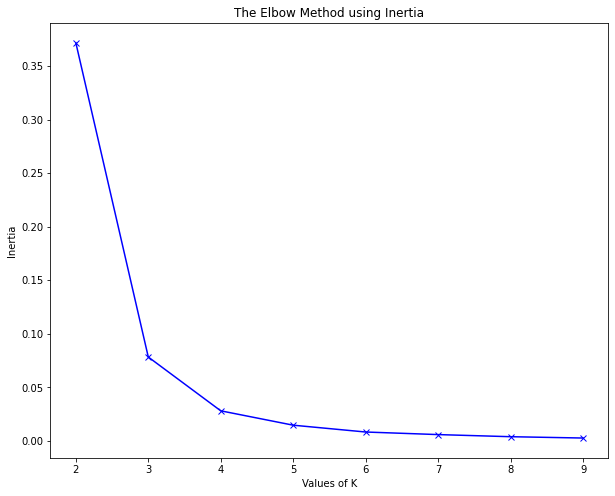

In [ ]:
# find 'k' value by Elbow Method
plt.figure(figsize=[10, 8])
inertia=[]
range_val=range(2,10)
for i in range_val:
  kmean=KMeans(n_clusters=i)
  kmean.fit_predict(X)
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [ ]:
kclusters = 4

toronto_grouped_clustering = ita.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 3, 0, 3, 3, 0, 3, 3, 0], dtype=int32)

In [ ]:
# unique value in target column
np.unique(kmeans.labels_)

array([0, 1, 2, 3], dtype=int32)

In [ ]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = ita.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [ ]:
to_merged.head()

Neighborhood  Coffee Shop  \
0                                        Agincourt     0.000000   
1                           Alderwood, Long Branch     0.142857   
2  Bathurst Manor, Wilson Heights, Downsview North     0.095238   
3                                  Bayview Village     0.000000   
4                Bedford Park, Lawrence Manor East     0.080000   

   Cluster Labels  
0               0  
1               2  
2               3  
3               0  
4               3

In [ ]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(2133, 9)


Neighborhood  Coffee Shop  Cluster Labels  Neighborhood Latitude  \
0    Agincourt          0.0               0                43.7942   
0    Agincourt          0.0               0                43.7942   
0    Agincourt          0.0               0                43.7942   
0    Agincourt          0.0               0                43.7942   
0    Agincourt          0.0               0                43.7942   

   Neighborhood Longitude                        Venue  Venue Latitude  \
0              -79.262029  Panagio's Breakfast & Lunch       43.792370   
0              -79.262029                El Pulgarcito       43.792648   
0              -79.262029                     Twilight       43.791999   
0              -79.262029                       Mark's       43.791179   
0              -79.262029              Commander Arena       43.794867   

   Venue Longitude             Venue Category  
0       -79.260203             Breakfast Spot  
0       -79.259208  Latin American Restaurant  
0       -79.258584                     Lounge  
0       -79.259714             Clothing Store  
0       -79.267989               Skating Rink

In [ ]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.tail()

(2133, 9)


Neighborhood  Coffee Shop  Cluster Labels  \
48  Kensington Market, Chinatown, Grange Park     0.044118               3   
48  Kensington Market, Chinatown, Grange Park     0.044118               3   
48  Kensington Market, Chinatown, Grange Park     0.044118               3   
48  Kensington Market, Chinatown, Grange Park     0.044118               3   
52                                    Leaside     0.093750               3   

    Neighborhood Latitude  Neighborhood Longitude          Venue  \
48              43.653206              -79.400049     Sonic Boom   
48              43.653206              -79.400049    Maker Pizza   
48              43.653206              -79.400049       Hibiscus   
48              43.653206              -79.400049  I Deal Coffee   
52              43.709060              -79.363452    Tim Hortons   

    Venue Latitude  Venue Longitude                 Venue Category  
48       43.650859       -79.396985                    Record Shop  
48       43.650401       -79.398040                    Pizza Place  
48       43.655454       -79.402439  Vegetarian / Vegan Restaurant  
48       43.655058       -79.403254                    Coffee Shop  
52       43.705629       -79.361028                    Coffee Shop

In [ ]:
to_merged['Venue Category'].value_counts()['Coffee Shop']

183

In [ ]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

In [ ]:
ita["Cluster Labels"] = kmeans.labels_
ita.head()

Neighborhood  Coffee Shop  \
0                                        Agincourt     0.000000   
1                           Alderwood, Long Branch     0.142857   
2  Bathurst Manor, Wilson Heights, Downsview North     0.095238   
3                                  Bayview Village     0.000000   
4                Bedford Park, Lawrence Manor East     0.080000   

   Cluster Labels  
0               0  
1               2  
2               3  
3               0  
4               3

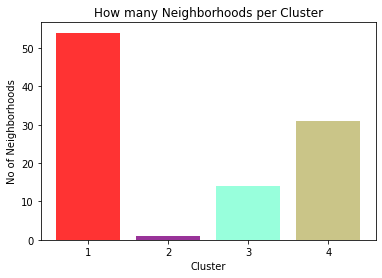

In [ ]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [ ]:
# How many neighborhoods in each cluster
ita['Cluster Labels'].value_counts()

0    54
3    31
2    14
1     1
Name: Cluster Labels, dtype: int64

In [ ]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

Borough                      Neighborhood
0        North York                         Parkwoods
1        North York                  Victoria Village
2  Downtown Toronto         Regent Park, Harbourfront
3        North York  Lawrence Manor, Lawrence Heights
4      Queen's Park     Ontario Provincial Government

In [ ]:
# Red 

cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1.head()

Borough     Neighborhood  Coffee Shop  Cluster Labels  \
0   North York        Parkwoods          0.0               0   
1   North York        Parkwoods          0.0               0   
2   North York        Parkwoods          0.0               0   
3  Scarborough   Malvern, Rouge          0.0               0   
4   North York  Don Mills North          0.0               0   

   Neighborhood Latitude  Neighborhood Longitude            Venue  \
0              43.753259              -79.329656  Brookbanks Park   
1              43.753259              -79.329656              KFC   
2              43.753259              -79.329656    Variety Store   
3              43.806686              -79.194353          Wendy’s   
4              43.745906              -79.352188       LA Fitness   

   Venue Latitude  Venue Longitude        Venue Category  
0       43.751976       -79.332140                  Park  
1       43.754387       -79.333021  Fast Food Restaurant  
2       43.751974       -79.333114     Food & Drink Shop  
3       43.807448       -79.199056  Fast Food Restaurant  
4       43.747665       -79.347077                   Gym

In [ ]:
# Purple 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2.head()

Borough Neighborhood  Coffee Shop  Cluster Labels  \
0  Scarborough       Woburn     0.666667               1   
1  Scarborough       Woburn     0.666667               1   
2  Scarborough       Woburn     0.666667               1   

   Neighborhood Latitude  Neighborhood Longitude               Venue  \
0              43.770992              -79.216917  Korean Grill House   
1              43.770992              -79.216917         Tim Hortons   
2              43.770992              -79.216917           Starbucks   

   Venue Latitude  Venue Longitude         Venue Category  
0       43.770812       -79.214502  Korean BBQ Restaurant  
1       43.770827       -79.223078            Coffee Shop  
2       43.770037       -79.221156            Coffee Shop

In [ ]:
# Blue
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3.head()

Borough               Neighborhood  Coffee Shop  Cluster Labels  \
0        North York           Victoria Village     0.250000               2   
1        North York           Victoria Village     0.250000               2   
2        North York           Victoria Village     0.250000               2   
3        North York           Victoria Village     0.250000               2   
4  Downtown Toronto  Regent Park, Harbourfront     0.159091               2   

   Neighborhood Latitude  Neighborhood Longitude                   Venue  \
0              43.725882              -79.315572             Tim Hortons   
1              43.725882              -79.315572               Portugril   
2              43.725882              -79.315572              Pizza Nova   
3              43.725882              -79.315572  Victoria Village Arena   
4              43.654260              -79.360636         TD Canada Trust   

   Venue Latitude  Venue Longitude         Venue Category  
0       43.725517       -79.313103            Coffee Shop  
1       43.725819       -79.312785  Portuguese Restaurant  
2       43.725824       -79.312860            Pizza Place  
3       43.723481       -79.315635           Hockey Arena  
4       43.652780       -79.356336                   Bank

In [ ]:
# Turquoise
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4.head()

Borough                      Neighborhood  Coffee Shop  Cluster Labels  \
0  North York  Lawrence Manor, Lawrence Heights     0.090909               3   
1  North York  Lawrence Manor, Lawrence Heights     0.090909               3   
2  North York  Lawrence Manor, Lawrence Heights     0.090909               3   
3  North York  Lawrence Manor, Lawrence Heights     0.090909               3   
4  North York  Lawrence Manor, Lawrence Heights     0.090909               3   

   Neighborhood Latitude  Neighborhood Longitude  \
0              43.718518              -79.464763   
1              43.718518              -79.464763   
2              43.718518              -79.464763   
3              43.718518              -79.464763   
4              43.718518              -79.464763   

                                   Venue  Venue Latitude  Venue Longitude  \
0                                  Roots       43.718214       -79.463893   
1  Kitchen Stuff Plus (Clearance Outlet)       43.719096       -79.462675   
2                             Le Château       43.719269       -79.460276   
3                             Lens Mills       43.719137       -79.461969   
4                            Fairweather       43.717878       -79.467246   

           Venue Category  
0                Boutique  
1  Furniture / Home Store  
2          Clothing Store  
3     Arts & Crafts Store  
4           Women's Store

In [ ]:
# Orange
cluster5 = to_merged.loc[to_merged['Cluster Labels'] == 4]
df_cluster5 = pd.merge(df_new, cluster5, on='Neighborhood')
df_cluster5.head()

Empty DataFrame
Columns: [Borough, Neighborhood, Coffee Shop, Cluster Labels, Neighborhood Latitude, Neighborhood Longitude, Venue, Venue Latitude, Venue Longitude, Venue Category]
Index: []

Text(0.5, 1.0, 'Average number of Coffee Shops per Cluster')

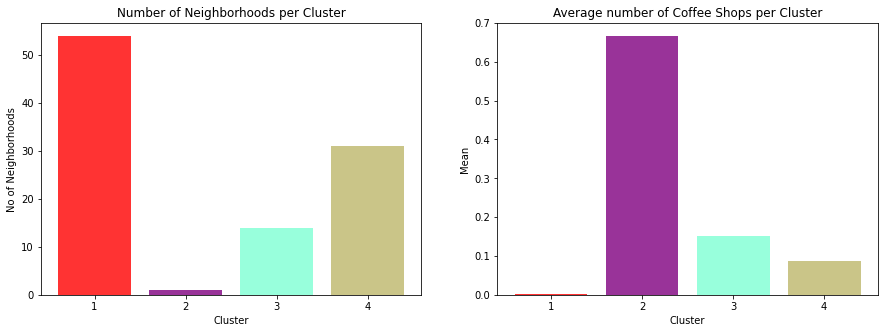

In [ ]:
plt.figure(figsize=(15,5))

# Plot-1 ( Number of Neighborhoods per Cluster )

plt.subplot(1,2,1)
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf_1 = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf_1, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('Number of Neighborhoods per Cluster')

# Plot-2 ( Average number of Coffee Shops per Cluster )

plt.subplot(1, 2, 2)
clusters_mean = [df_cluster1['Coffee Shop'].mean(),df_cluster2['Coffee Shop'].mean(),df_cluster3['Coffee Shop'].mean(),
                df_cluster4['Coffee Shop'].mean()]
y_pos = np.arange(len(objects))
perf_2 = clusters_mean
plt.bar(y_pos, perf_2, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Coffee Shops per Cluster')